## Setup

In [1]:
%matplotlib inline

import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / "src"))

from tictactoe.agents.jmetal_agent import (
    run_multiobjective_evolution,
    select_solution_from_pareto,
)
from tictactoe.agents.genetic_agent import load_weights

plt.style.use("dark_background")

## Run Multi-Objective Evolution

In [2]:
# Run jMetalPy NSGA-II
result = run_multiobjective_evolution(
    pop_size=50,
    max_evaluations=5000,
    algorithm="NSGA-II",
    n_games=10,
    seed=42,
)

print(f"Pareto Front Size: {len(result.pareto_front)}")
print(f"Average Fitness: {result.history[-1].avg_fitness:.3f}")
print(f"Average Complexity: {result.history[-1].avg_complexity:.2f}")

[2025-12-13 11:26:09,562] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-12-13 11:26:09,563] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-12-13 11:26:09,827] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-12-13 11:26:09,827] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-12-13 11:26:34,894] [jmetal.core.algorithm] [DEBUG] Finished!


Pareto Front Size: 50
Average Fitness: 0.841
Average Complexity: 0.86


## Visualize Pareto Front

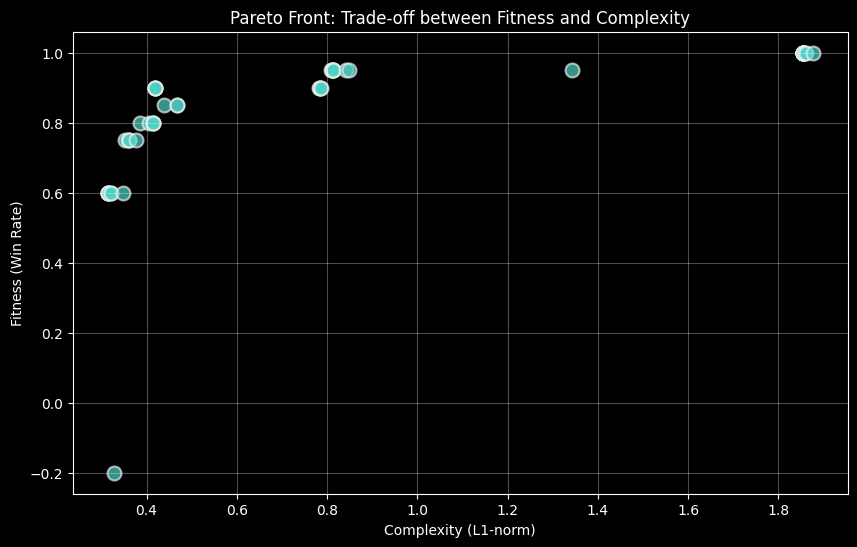

Fitness range: [-0.200, 1.000]
Complexity range: [0.31, 1.88]


In [3]:
# Extract objectives
fitness_values = [obj[0] for obj in result.pareto_objectives]
complexity_values = [obj[1] for obj in result.pareto_objectives]

# Plot Pareto front
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    complexity_values,
    fitness_values,
    s=100,
    c="#4FD1C5",
    alpha=0.7,
    edgecolors="#EEEEEE",
    linewidths=1.5,
)
ax.set_xlabel("Complexity (L1-norm)")
ax.set_ylabel("Fitness (Win Rate)")
ax.set_title("Pareto Front: Trade-off between Fitness and Complexity")
ax.grid(True, alpha=0.3)
plt.show()

print(f"Fitness range: [{min(fitness_values):.3f}, {max(fitness_values):.3f}]")
print(f"Complexity range: [{min(complexity_values):.2f}, {max(complexity_values):.2f}]")

## Select Solutions from Pareto Front

In [4]:
# Try different selection strategies
strategies = ["fitness", "simple", "balanced"]

for strategy in strategies:
    weights = select_solution_from_pareto(result, strategy=strategy)
    idx = result.pareto_front.index(weights)
    fitness, complexity = result.pareto_objectives[idx]

    print(f"\n{strategy.upper()} Strategy:")
    print(f"  Fitness: {fitness:.3f}")
    print(f"  Complexity: {complexity:.2f}")
    print(f"  Weights: {[f'{w:.2f}' for w in weights]}")


FITNESS Strategy:
  Fitness: 1.000
  Complexity: 1.85
  Weights: ['-0.22', '-0.33', '-0.00', '-0.36', '-0.03', '-0.29', '-0.11', '-0.25', '-0.25']

SIMPLE Strategy:
  Fitness: 0.600
  Complexity: 0.31
  Weights: ['-0.06', '-0.01', '0.06', '-0.03', '-0.00', '-0.03', '0.07', '0.01', '0.05']

BALANCED Strategy:
  Fitness: 0.900
  Complexity: 0.42
  Weights: ['-0.01', '-0.07', '0.08', '-0.05', '-0.00', '-0.03', '0.08', '-0.04', '0.05']


## Visualize Selected Solutions

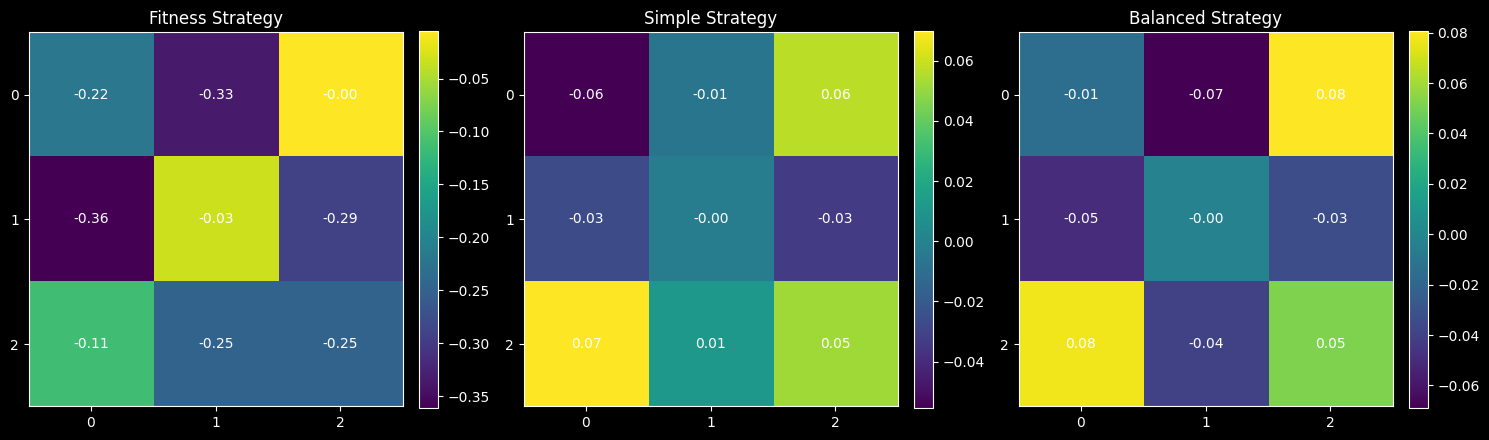

In [5]:
# Plot heatmaps for different strategies
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, strategy in enumerate(strategies):
    weights = select_solution_from_pareto(result, strategy=strategy)
    grid = np.array(weights).reshape(3, 3)

    ax = axes[idx]
    im = ax.imshow(grid, cmap="viridis")
    ax.set_title(f"{strategy.capitalize()} Strategy")
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))

    # Add weight values
    for (i, j), value in np.ndenumerate(grid):
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="white")

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Compare with DEAP Single-Objective

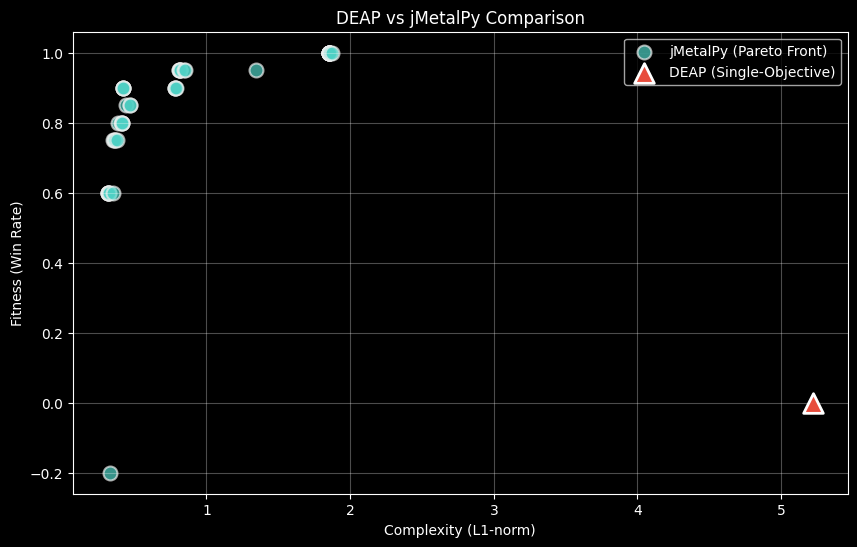

DEAP Complexity: 5.22


In [6]:
# Load DEAP weights (if available)
try:
    deap_path = Path("../src/tictactoe/weights/best/best_weights.pkl")
    if deap_path.exists():
        deap_weights = load_weights(deap_path)
        deap_complexity = sum(abs(w) for w in deap_weights)

        # Plot comparison
        fig, ax = plt.subplots(figsize=(10, 6))

        # jMetalPy Pareto front
        ax.scatter(
            complexity_values,
            fitness_values,
            s=100,
            c="#4FD1C5",
            alpha=0.7,
            edgecolors="#EEEEEE",
            linewidths=1.5,
            label="jMetalPy (Pareto Front)",
        )

        # DEAP single point (complexity only, fitness would need evaluation)
        ax.scatter(
            [deap_complexity],
            [0],  # Placeholder
            s=200,
            c="#E74C3C",
            marker="^",
            edgecolors="#FFFFFF",
            linewidths=2,
            label="DEAP (Single-Objective)",
            zorder=10,
        )

        ax.set_xlabel("Complexity (L1-norm)")
        ax.set_ylabel("Fitness (Win Rate)")
        ax.set_title("DEAP vs jMetalPy Comparison")
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.show()

        print(f"DEAP Complexity: {deap_complexity:.2f}")
    else:
        print("DEAP weights not found. Run 'tictactoe evolve' first.")
except Exception as e:
    print(f"Could not load DEAP weights: {e}")

## Analysis: Trade-offs

### Key Insights:

1. **Pareto Front**: Shows the trade-off between maximizing fitness (win rate) and minimizing complexity (weight magnitude)
2. **Multiple Solutions**: Unlike DEAP's single solution, jMetalPy provides multiple optimal solutions with different trade-offs
3. **Selection Strategies**:
   - **Fitness**: Best performance, may be more complex
   - **Simple**: Minimal complexity, may sacrifice some performance
   - **Balanced**: Middle ground between fitness and simplicity

### When to use jMetalPy:
- When you want to explore trade-offs between objectives
- When you need multiple solution options
- When model interpretability/simplicity matters
- When you want to avoid overfitting through complexity control

## Save Results

In [7]:
from tictactoe.agents.jmetal_agent import save_pareto_front

# Save Pareto front
output_path = Path("../results/experiments/jmetal_pareto_front.pkl")
save_pareto_front(result, output_path)
print(f"Saved Pareto front to: {output_path}")

# Save selected solution
best_weights = select_solution_from_pareto(result, strategy="balanced")
print(f"\nSelected solution (balanced): {[f'{w:.2f}' for w in best_weights]}")

Saved Pareto front to: ../results/experiments/jmetal_pareto_front.pkl

Selected solution (balanced): ['-0.01', '-0.07', '0.08', '-0.05', '-0.00', '-0.03', '0.08', '-0.04', '0.05']
